## Predicting UFC Fight Outcomes

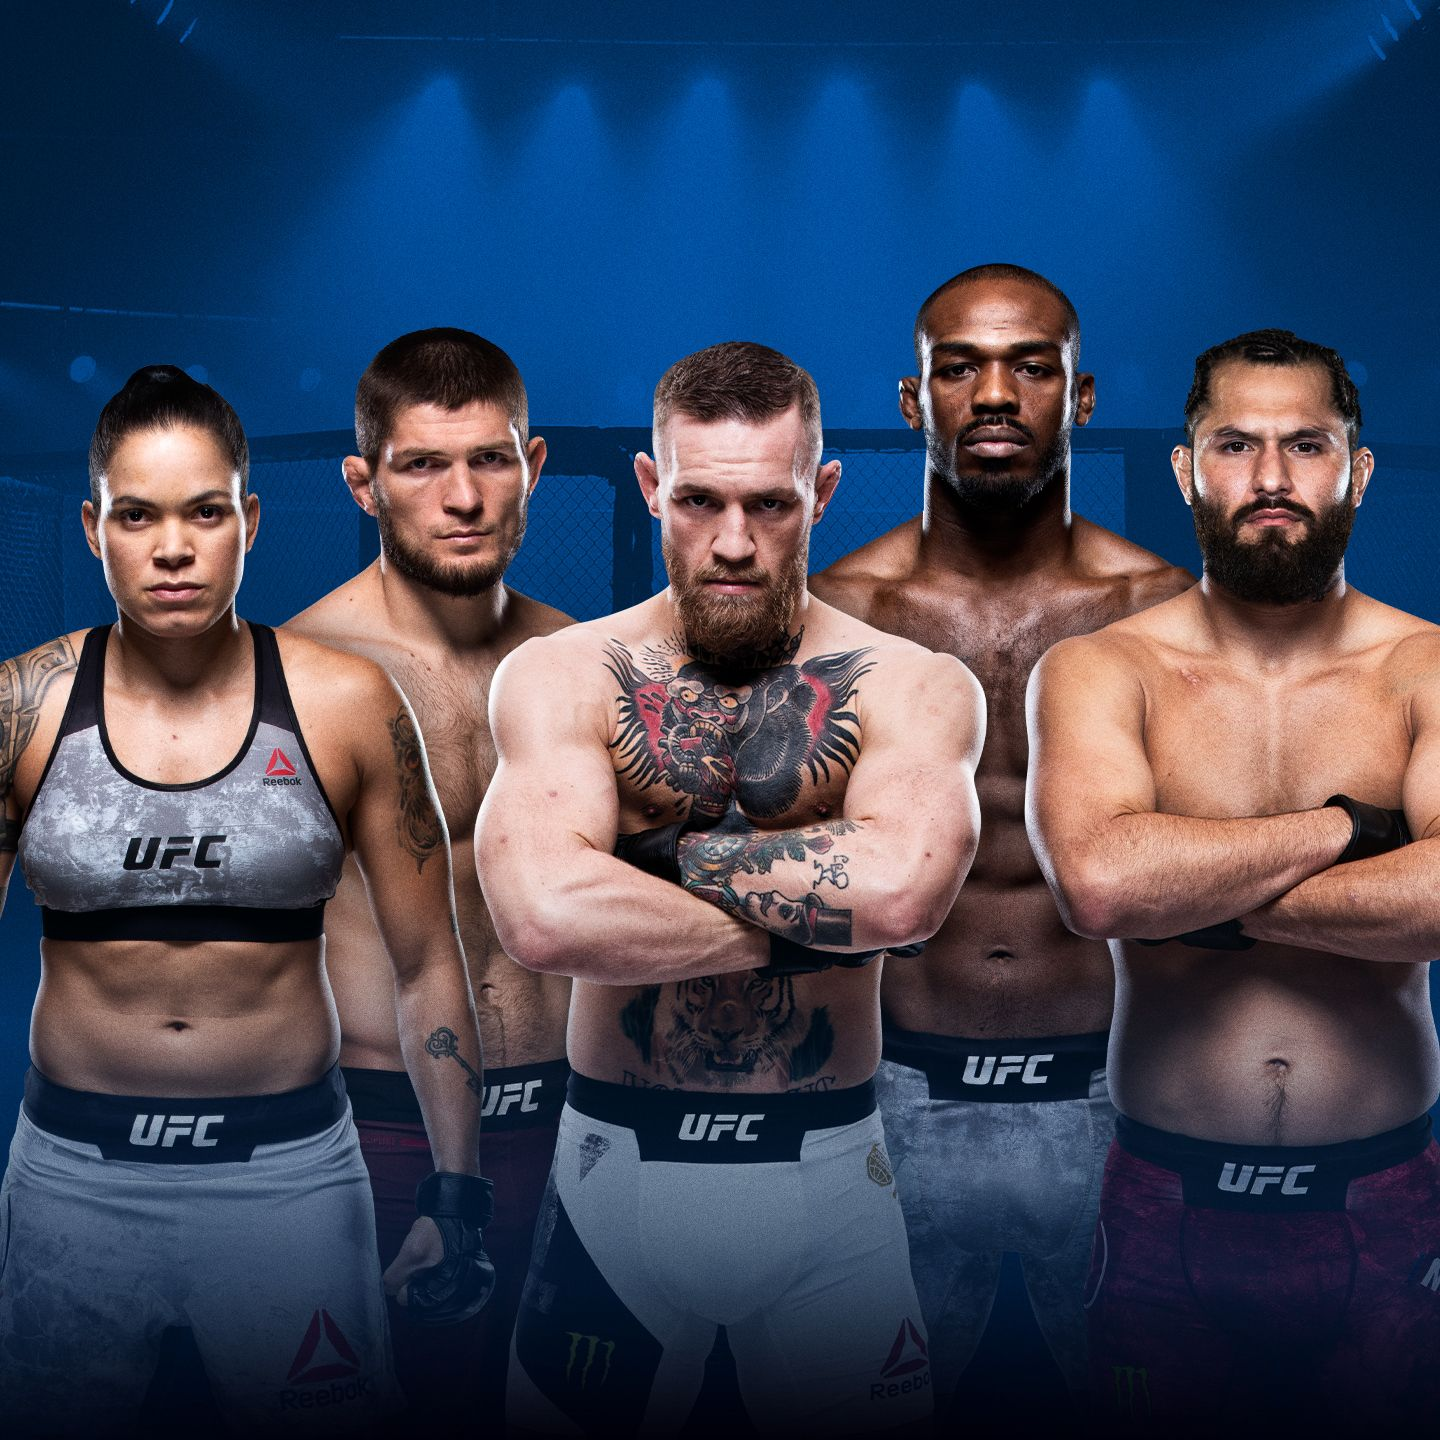

In [4]:
from IPython.display import Image
Image(filename='ufc.jpg', width=400, height=200)

### Introduction
This notebook will accomplish the following tasks:

#### Section 01: Exploratory Data Analysis

- What are the weight classes and number of fights by gender?
- What is the ratio of men to women?
- Which fighter had the most fights?


#### Section 02: Predictive Model

- Predictive model that'll predict the winner of 13 fights.

In [51]:
import pandas as pd
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import date
from tabulate import tabulate
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
import sys, warnings, os

In [52]:
# This will help us ignore max-iteration warnings if we cross validate scores.

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

In [6]:
# Loading in ufc-master csv file.
df= pd.read_csv('ufc-master.csv')

In [19]:
df.head()

,R_fighter,B_fighter,R_odds,B_odds,R_ev,B_ev,date,location,country,Winner,title_bout,weight_class,gender,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,B_avg_TD_landed,B_avg_TD_pct,B_longest_win_streak,B_losses,B_total_rounds_fought,B_total_title_bouts,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO/TKO,B_win_by_Submission,B_win_by_TKO_Doctor_Stoppage,B_wins,B_Stance,B_Height_cms,B_Reach_cms,B_Weight_lbs,R_current_lose_streak,R_current_win_streak,R_draw,R_avg_SIG_STR_landed,R_avg_SIG_STR_pct,R_avg_SUB_ATT,R_avg_TD_landed,R_avg_TD_pct,R_longest_win_streak,R_losses,R_total_rounds_fought,R_total_title_bouts,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,R_age,B_age,lose_streak_dif,win_streak_dif,longest_win_streak_dif,win_dif,loss_dif,total_round_dif,total_title_bout_dif,ko_dif,sub_dif,height_dif,reach_dif,age_dif,sig_str_dif,avg_sub_att_dif,avg_td_dif,empty_arena,constant_1,B_match_weightclass_rank,R_match_weightclass_rank,R_Women's Flyweight_rank,R_Women's Featherweight_rank,R_Women's Strawweight_rank,R_Women's Bantamweight_rank,R_Heavyweight_rank,R_Light Heavyweight_rank,R_Middleweight_rank,R_Welterweight_rank,R_Lightweight_rank,R_Featherweight_rank,R_Bantamweight_rank,R_Flyweight_rank,R_Pound-for-Pound_rank,B_Women's Flyweight_rank,B_Women's Featherweight_rank,B_Women's Strawweight_rank,B_Women's Bantamweight_rank,B_Heavyweight_rank,B_Light Heavyweight_rank,B_Middleweight_rank,B_Welterweight_rank,B_Lightweight_rank,B_Featherweight_rank,B_Bantamweight_rank,B_Flyweight_rank,B_Pound-for-Pound_rank,better_rank,finish,finish_details,finish_round,finish_round_time,total_fight_time_secs,r_dec_odds,b_dec_odds,r_sub_odds,b_sub_odds,r_ko_odds,b_ko_odds
0,Uriah Hall,Sean Strickland,175,-210,175.000000,47.619048,2021-07-31,"Las Vegas, Nevada, USA",USA,Blue,False,Middleweight,MALE,5,0,4,0,5.45,0.40,0.3,1.32,0.61,4,3,33,0,0,2,4,3,1,0,10,Orthodox,185.42,193.04,185,0,4,0,3.47,0.49,0.2,0.58,0.38,4,7,37,0,0,1,1,8,0,0,10,Orthodox,182.88,200.66,185,37,30,0,0,0,0,-4,-4,0,-5,1,2.54,-7.62,-7,1.98,0.1,0.74,1,1,11.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,Red,U-DEC,NaN,5.0,5:00,1500.0,650.0,225.0,2500.0,800.0,275.0,165.0
1,Cheyanne Buys,Gloria de Paula,-145,125,68.965517,125.000000,2021-07-31,"Las Vegas, Nevada, USA",USA,Red,False,Women's Strawweight,FEMALE,3,1,0,0,3.39,0.54,1.0,0.00,0.00,1,1,6,0,0,0,1,0,0,0,1,Orthodox,165.10,170.18,115,1,0,0,4.32,0.54,0.0,0.48,0.33,1,1,6,0,0,0,1,0,0,0,1,Switch,160.02,160.02,115,26,26,0,0,0,0,0,0,0,0,0,5.08,10.16,0,-0.93,1.0,-0.48,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,neither,KO/TKO,Kick,1.0,1:00,60.0,100.0,200.0,800.0,1400.0,900.0,900.0
2,Niklas Stolze,Jared Gooden,-180,155,55.555556,155.000000,2021-07-31,"Las Vegas, Nevada, USA",USA,Blue,False,Welterweight,MALE,3,2,0,0,5.04,0.42,0.0,0.96,1.00,0,2,6,0,0,0,0,0,0,0,0,Orthodox,182.88,195.58,170,1,0,0,2.29,0.43,0.0,0.93,1.00,0,1,3,0,0,0,0,0,0,0,0,Switch,182.88,190.50,170,28,27,1,0,0,0,1,3,0,0,0,0.00,5.08,-1,2.75,0.0,0.03,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,neither,KO/TKO,Punch,1.0,1:08,68.0,180.0,300.0,600.0,1200.0,300.0,600.0
3,Collin Anglin,Melsik Baghdasaryan,135,-155,135.000000,64.516129,2021-07-31,"Las Vegas, Nevada, USA",USA,Blue,False,Featherweight,MALE,3,0,1,0,6.69,0.62,0.0,0.00,0.00,1,0,3,0,0,0,1,0,0,0,1,Southpaw,175.26,177.80,145,0,1,0,5.18,0.54,0.0,2.75,0.80,1,0,3,0,0,0,1,0,0,0,1,Orthodox,175.26,180.34,145,28,29,0,0,0,0,0,0,0,0,0,0.00,-2.54,1,1.51,0.0,-2.75,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,neither

### Section 01: Exploratory Data Analysis

#### What are the weight classes and number of fights by gender?
- We can see the weight classes below and that men compete in more weight classes then women. 
- For men, the most popular weight classes are lightweight, welterweight and featherweight.
- For women, the most popular weight classeas are: strawweight and bantamweight.

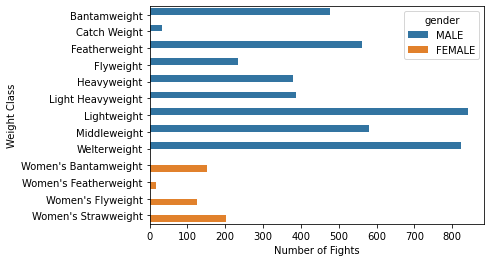

In [10]:
sns.countplot(data=df.sort_values(by='weight_class') , y = 'weight_class', hue ='gender')
plt.xlabel('Number of Fights')
plt.ylabel('Weight Class')
plt.show()

#### What is the ratio of men to women? 
- The majority of fighters are men.

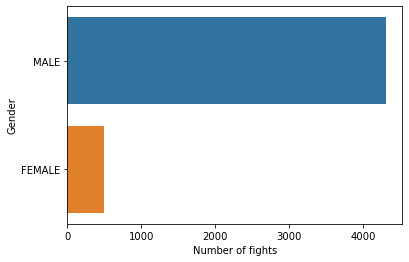

In [11]:
sns.countplot(data=df , y = 'gender')
plt.ylabel('Gender')
plt.xlabel('Number of fights')
plt.show();

#### Which fighter had the most fights?
- Donald Cerrone had the most fights. 
- None of the women ranked in the top when it came to fights.

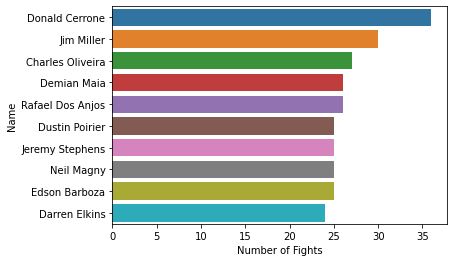

In [12]:
temp_fighter_list = pd.DataFrame(df['R_fighter'].append(df['B_fighter']).value_counts()).reset_index()
temp_fighter_list.columns = ['Name','count']
sns.barplot(data=temp_fighter_list.head(10),y = 'Name' ,x = 'count') # order = temp_fighter_list['Name'].value_counts())
plt.xlabel('Number of Fights')
plt.show()

### Section 02: Predictive Model

In [20]:
# Loading in upcoming-event csv file.
df_upcoming = pd.read_csv("upcoming-event.csv")

In [18]:
df_upcoming.head()

,R_fighter,B_fighter,R_odds,B_odds,R_ev,B_ev,date,location,country,Winner,title_bout,weight_class,gender,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,B_avg_TD_landed,B_avg_TD_pct,B_longest_win_streak,B_losses,B_total_rounds_fought,B_total_title_bouts,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO/TKO,B_win_by_Submission,B_win_by_TKO_Doctor_Stoppage,B_wins,B_Stance,B_Height_cms,B_Reach_cms,B_Weight_lbs,R_current_lose_streak,R_current_win_streak,R_draw,R_avg_SIG_STR_landed,R_avg_SIG_STR_pct,R_avg_SUB_ATT,R_avg_TD_landed,R_avg_TD_pct,R_longest_win_streak,R_losses,R_total_rounds_fought,R_total_title_bouts,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,R_age,B_age,lose_streak_dif,win_streak_dif,longest_win_streak_dif,win_dif,loss_dif,total_round_dif,total_title_bout_dif,ko_dif,sub_dif,height_dif,reach_dif,age_dif,sig_str_dif,avg_sub_att_dif,avg_td_dif,empty_arena,constant_1,B_match_weightclass_rank,R_match_weightclass_rank,R_Women's Flyweight_rank,R_Women's Featherweight_rank,R_Women's Strawweight_rank,R_Women's Bantamweight_rank,R_Heavyweight_rank,R_Light Heavyweight_rank,R_Middleweight_rank,R_Welterweight_rank,R_Lightweight_rank,R_Featherweight_rank,R_Bantamweight_rank,R_Flyweight_rank,R_Pound-for-Pound_rank,B_Women's Flyweight_rank,B_Women's Featherweight_rank,B_Women's Strawweight_rank,B_Women's Bantamweight_rank,B_Heavyweight_rank,B_Light Heavyweight_rank,B_Middleweight_rank,B_Welterweight_rank,B_Lightweight_rank,B_Featherweight_rank,B_Bantamweight_rank,B_Flyweight_rank,B_Pound-for-Pound_rank,better_rank,finish,finish_details,finish_round,finish_round_time,total_fight_time_secs,r_dec_odds,b_dec_odds,r_sub_odds,b_sub_odds,r_ko_odds,b_ko_odds
0,Derrick Lewis,Ciryl Gane,260,-335,260.000000,29.850746,2021-08-07,"Houston, Texas, USA",USA,NaN,True,Heavyweight,MALE,5,0,6,0,5.13,0.54,0.3,0.82,0.21,6,0,19,-1,0,0,3,1,2,0,6,Orthodox,193.04,205.74,245,0,4,0,2.59,0.50,0.0,0.52,0.26,6,5,48,0,0,2,2,12,0,0,16,Orthodox,190.50,200.66,260,36,31,0,2,0,-10,-5,-29,-1,-11,2,2.54,5.08,-5,2.54,0.3,0.30,0,1,3.0,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Red,NaN,NaN,NaN,NaN,NaN,900.0,195.0,NaN,NaN,NaN,NaN
1,Jose Aldo,Pedro Munhoz,-130,110,76.923077,110.000000,2021-08-07,"Houston, Texas, USA",USA,NaN,False,Bantamweight,MALE,3,0,1,0,5.60,0.43,0.8,0.68,0.21,4,5,34,0,0,0,3,3,3,0,9,Orthodox,167.64,165.10,135,0,1,0,3.45,0.45,0.1,0.57,0.56,15,6,76,12,0,0,8,11,0,0,19,Orthodox,170.18,177.80,135,34,34,0,0,-11,-10,-1,-42,-12,-8,3,-2.54,-12.70,0,2.15,0.7,0.11,0,1,8.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,Red,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Michael Chiesa,Vicente Luque,115,-135,115.000000,74.074074,2021-08-07,"Houston, Texas, USA",USA,NaN,False,Welterweight,MALE,3,0,3,0,5.74,0.54,0.9,0.66,0.50,6,3,31,0,0,1,0,8,4,0,13,Orthodox,180.34,190.50,170,0,4,0,1.89,0.40,0.9,3.60,0.52,4,4,35,0,0,0,5,0,6,0,11,Southpaw,185.42,190.50,170,33,29,0,-1,2,2,-1,-4,0,8,-2,-5.08,0.00,-4,3.85,0.0,-2.94,0,1,6.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,Red,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Tecia Torres,Angela Hill,-130,110,76.923077,110.000000,2021-08-07,"Houston, Texas, USA",USA,NaN,False,Women's Strawweight,FEMALE,3,0,1,0,5.66,0.50,0.1,0.45,0.36,3,9,48,0,0,0,6,2,0,0,8,Orthodox,160.02,162.56,115,0,2,0,4.30,0.47,0.1,0.68,0.15,3,5,36,0,0,0,6,1,1,0,8,Orthodox,154.94,152.40,115,31,36,0,-1,0,0,4,12,0,1,-1,5.08,10.16,5,1.36,0.0,-0.23,0,1,12.0,10.0,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Red,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Song Yadong

In [22]:
# We're going to combine the upcoming events csv file with the master csv file. 
# This will make it easier to clean all the data at the same time.
df_combined = df_upcoming.append(df)

In [23]:
# we're going to put labels into the dataframe.
df_combined['label'] = ''

In [24]:
# We're converting Red' and 'Blue' to 0 and 1
mask = df_combined['Winner'] == 'Red'
df_combined['label'][mask] = 0
mask = df_combined['Winner'] == 'Blue'
df_combined['label'][mask] = 1

<ipython-input-24-2511b30f1c47>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined['label'][mask] = 0
<ipython-input-24-2511b30f1c47>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined['label'][mask] = 1


In [25]:
# Making sure the label field is numeric.
df_combined['label'] = pd.to_numeric(df_combined['label'], errors='coerce')

In [26]:
# Making sure the date column is in datetime.
df_combined['date'] = pd.to_datetime(df['date'])

In [28]:
# Getting the number of upcoming fights
num_upcoming_fights = len(df_upcoming)

In [30]:
# Copying the labels to their own dataframe.
label_df = df_combined['label']

In [33]:
# Splitting the train set from the test set

df_train = df_combined[num_upcoming_fights:]
label_train = label_df[num_upcoming_fights:]

df_test = df_combined[:num_upcoming_fights]
label_test = label_df[:num_upcoming_fights]

In [34]:
# Making sure the sizes are the same.
print(len(df_test))
print(len(label_test))

print(len(df_train))
print(len(label_train))

13
13
4813
4813


In [39]:
# Picking a model.
my_model = DecisionTreeClassifier(max_depth=5)

In [37]:
# Picking some features.
my_features = ['R_odds', 'B_Stance']

In [38]:
# Grabbing the names of the fighters for the upcoming event
fighters_test = df_test[['R_fighter', 'B_fighter']]

In [40]:
# Making sure that the dataframes only contain relevant features
df_train_prepped = df_train[my_features].copy()
df_test_prepped = df_test[my_features].copy()

In [41]:
df_train_prepped = pd.get_dummies(df_train_prepped)
df_test_prepped = pd.get_dummies(df_test_prepped)

In [42]:
# Ensuring that both sets are dummified the same.
df_train_prepped, df_test_prepped = df_train_prepped.align(df_test_prepped, join='left', axis=1)  

In [43]:
df_test_prepped = df_test_prepped.fillna(0)

In [44]:
# Since we may have dropped some rows we need to drop the matching rows in the labels
label_train_prepped = label_train[label_train.index.isin(df_train_prepped.index)]
label_test_prepped = label_test[label_test.index.isin(df_test_prepped.index)]
fighters_test_prepped = fighters_test[fighters_test.index.isin(df_test_prepped.index)]

In [45]:
# Testing that the lengths match.
print(len(label_train_prepped))
print(len(df_train_prepped))
print(len(label_test_prepped))
print(len(df_test_prepped))
print(len(fighters_test_prepped))

4813
4813
13
13
13


In [46]:
# Training the model.
my_model.fit(df_train_prepped, label_train_prepped)

DecisionTreeClassifier(max_depth=5)

In [48]:
# Getting predictions.
predictions = my_model.predict(df_test_prepped)

In [49]:
# Zipping the fighters to predictions.  
fighters_array = fighters_test_prepped.to_numpy()
prediction_list = np.array(list(zip(fighters_array, predictions)))
for p in prediction_list:
    if p[1] == 0.0:
        print(f"RED fighter {p[0][0]} is predicted to win over {p[0][1]}")
    else:
        print(f"BLUE fighter {p[0][1]} is predicted to win over {p[0][0]}")

BLUE fighter Ciryl Gane is predicted to win over Derrick Lewis
RED fighter Jose Aldo is predicted to win over Pedro Munhoz
BLUE fighter Vicente Luque is predicted to win over Michael Chiesa
RED fighter Tecia Torres is predicted to win over Angela Hill
RED fighter Song Yadong is predicted to win over Casey Kenney
BLUE fighter Rafael Fiziev is predicted to win over Bobby Green
BLUE fighter Drako Rodriguez is predicted to win over Vince Morales
RED fighter Alonzo Menifield is predicted to win over Ed Herman
BLUE fighter Jessica Penne is predicted to win over Karolina Kowalkiewicz
RED fighter Manel Kape is predicted to win over Ode Osbourne
RED fighter Miles Johns is predicted to win over Anderson Dos Santos
RED fighter Victoria Leonardo is predicted to win over Melissa Gatto
RED fighter Johnny Munoz is predicted to win over Jamey Simmons


<ipython-input-49-83c903b893d1>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  prediction_list = np.array(list(zip(fighters_array, predictions)))
